### 01. Libraries

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gymnasium as gym  # Switch to Gymnasium
from IPython import display
import imageio
import os
import pickle

### 02. Initialize the environment

In [22]:
# Create the environment with render_mode set to 'rgb_array'
TIME_LIMIT = 200  # Standard TimeLimit for MountainCar-v0
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env = gym.wrappers.TimeLimit(env, max_episode_steps=TIME_LIMIT)  # Wrap with TimeLimit

# Action mapping
actions = {0: 'left', 1: 'stop', 2: 'right'}

### 03. Define Q-Learning Parameters and Initialize the Q-Table

In [23]:
# Q-Learning parameters
alpha = 0.1        # Learning rate
gamma = 0.99       # Discount factor
epsilon = 1.0      # Initial exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995

# Discretization parameters
n_bins = (40, 40)  # Increased number of bins for position and velocity
position_bins = np.linspace(-1.2, 0.6, n_bins[0] - 1)
velocity_bins = np.linspace(-0.07, 0.07, n_bins[1] - 1)

# Initialize Q-table with zeros
Q_table = np.zeros(n_bins + (env.action_space.n,))

# Tracking variables
successes = []  # List to track successful episodes
rewards = []    # List to store rewards for each episode
steps_taken = []  # List to store steps taken per episode

### 04. Discretize the Observation Space

In [24]:
def discretize(obs):
    position, velocity = obs
    position_idx = np.digitize(position, position_bins)
    velocity_idx = np.digitize(velocity, velocity_bins)
    return (position_idx, velocity_idx)

### 05. Implement the Q-Learning Algorithm

In [25]:
# Training parameters
n_episodes = 100000
max_steps = TIME_LIMIT
success_threshold = 0.5  # Position threshold to consider the task as solved

for episode in range(1, n_episodes + 1):
    obs, info = env.reset(seed=episode)
    state = discretize(obs)
    total_reward = 0
    done = False
    
    for step in range(max_steps):
        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[state])
        
        # Take action
        next_obs, reward, done, truncated, info = env.step(action)
        next_state = discretize(next_obs)
        
        # Update Q-table
        best_next_action = np.argmax(Q_table[next_state])
        td_target = reward + gamma * Q_table[next_state][best_next_action]
        td_error = td_target - Q_table[state][action]
        Q_table[state][action] += alpha * td_error
        
        state = next_state
        total_reward += reward
        
        if done or truncated:
            # **Corrected Success Tracking: Check next_obs for goal condition**
            if next_obs[0] >= success_threshold:
                successes.append(1)
            else:
                successes.append(0)
            steps_taken.append(step + 1)  # Steps are zero-indexed
            break
    
    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    
    rewards.append(total_reward)
    
    # Optional: Print progress every 1000 episodes
    if episode % 1000 == 0:
        avg_reward = np.mean(rewards[-1000:])
        success_rate = np.mean(successes[-1000:]) * 100
        avg_steps = np.mean(steps_taken[-1000:])
        print(f"Episode {episode}: Average Reward: {avg_reward:.2f}, Success Rate: {success_rate:.2f}%, Average Steps: {avg_steps:.2f}, Epsilon: {epsilon:.3f}")
        
        # Check if the agent has solved the environment
        if success_rate > 90:
            print(f"Environment solved in {episode} episodes!")
            # Optionally, continue training instead of breaking
            # break

env.close()

Episode 1000: Average Reward: -200.00, Success Rate: 0.00%, Epsilon: 0.010
Episode 2000: Average Reward: -199.92, Success Rate: 0.40%, Epsilon: 0.010
Episode 3000: Average Reward: -198.10, Success Rate: 8.80%, Epsilon: 0.010
Episode 4000: Average Reward: -194.75, Success Rate: 26.30%, Epsilon: 0.010
Episode 5000: Average Reward: -193.73, Success Rate: 33.00%, Epsilon: 0.010
Episode 6000: Average Reward: -187.28, Success Rate: 55.30%, Epsilon: 0.010
Episode 7000: Average Reward: -181.57, Success Rate: 60.20%, Epsilon: 0.010
Episode 8000: Average Reward: -175.02, Success Rate: 74.30%, Epsilon: 0.010
Episode 9000: Average Reward: -170.63, Success Rate: 84.40%, Epsilon: 0.010
Episode 10000: Average Reward: -161.27, Success Rate: 89.70%, Epsilon: 0.010
Episode 11000: Average Reward: -157.84, Success Rate: 95.90%, Epsilon: 0.010
Environment solved in 11000 episodes!


### 06. Plot the training rewards

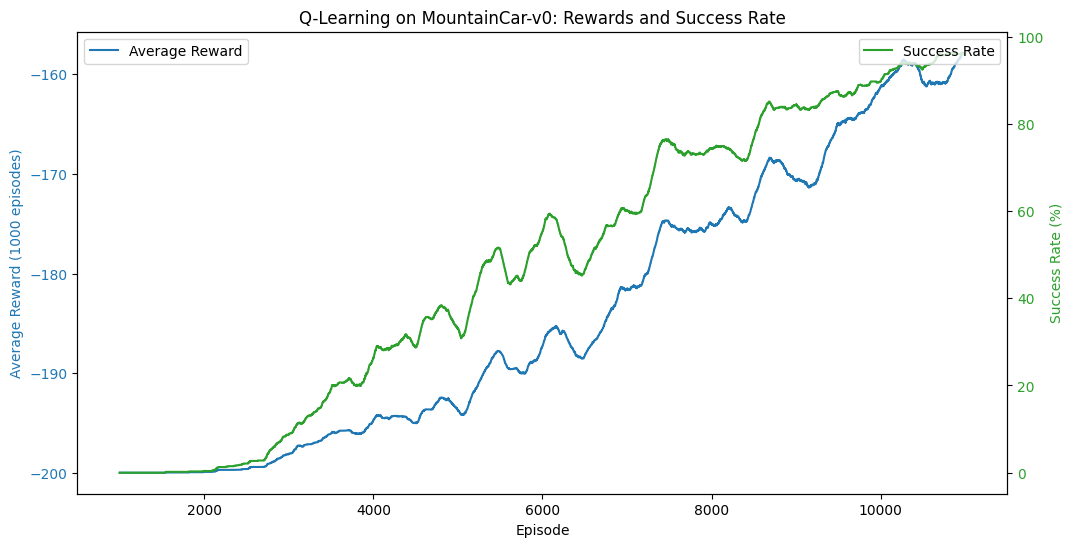

In [26]:
# Calculate moving averages
window = 1000
moving_avg_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')
moving_avg_success = np.convolve(successes, np.ones(window)/window, mode='valid') * 100  # Percentage
moving_avg_steps = np.convolve(steps_taken, np.ones(window)/window, mode='valid')

# Plotting the rewards, success rate, and steps taken
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Reward (1000 episodes)', color=color)
ax1.plot(range(window-1, len(rewards)), moving_avg_rewards, color=color, label='Average Reward')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Success Rate (%)', color=color)  # We already handled the x-label with ax1
ax2.plot(range(window-1, len(successes)), moving_avg_success, color=color, label='Success Rate')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

ax3 = ax1.twinx()  # Instantiate a third axes that shares the same x-axis
ax3.spines["right"].set_position(("axes", 1.1))  # Offset the third y-axis
color = 'tab:red'
ax3.set_ylabel('Average Steps Taken (1000 episodes)', color=color)
ax3.plot(range(window-1, len(steps_taken)), moving_avg_steps, color=color, label='Average Steps')
ax3.tick_params(axis='y', labelcolor=color)
ax3.legend(loc='upper center')

plt.title('Q-Learning on MountainCar-v0: Rewards, Success Rate, and Steps Taken')
plt.show()

### 07. Save the Trained Q-Table

In [27]:
# Save the Q-table
with open('q_table.pkl', 'wb') as f:
    pickle.dump(Q_table, f)

print("Q-table saved successfully.")

Q-table saved successfully.


### 08. Define a Function to Run the Trained Agent and Save Frames for GIF

In [28]:
def run_agent(env, Q_table, discretize_func, render=True, save_gif=True, gif_name='mountain_car_q_learning.gif'):
    frames = []
    obs, info = env.reset()
    state = discretize_func(obs)
    done = False
    truncated = False
    total_reward = 0
    step = 0
    
    while not (done or truncated):
        if render:
            frame = env.render()
            if frame is not None:
                frames.append(frame)
        
        # Choose the best action
        action = np.argmax(Q_table[state])
        
        # Take action
        next_obs, reward, done, truncated, info = env.step(action)
        next_state = discretize_func(next_obs)
        total_reward += reward
        state = next_state
        step += 1
    
    if save_gif:
        # Save frames as a GIF
        imageio.mimsave(gif_name, frames, fps=30)
        print(f"GIF saved as {gif_name}")
    
    env.close()
    return total_reward, step

### 09. Run the Trained Agent and Save the GIF

GIF saved as mountain_car_q_learning.gif
Total Reward: -158.0, Steps Taken: 158


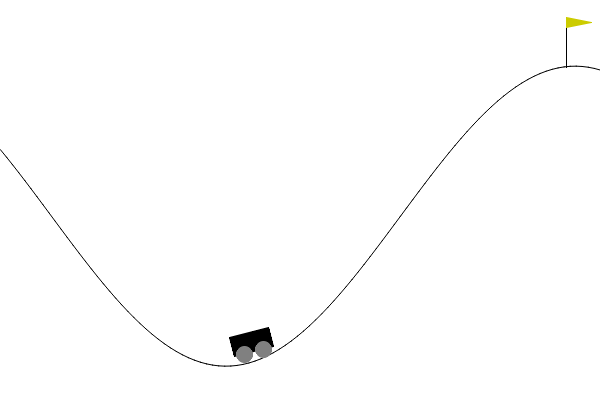

In [29]:
# Re-initialize the environment for testing
test_env = gym.make("MountainCar-v0", render_mode="rgb_array")
test_env = gym.wrappers.TimeLimit(test_env, max_episode_steps=TIME_LIMIT)  # Wrap with TimeLimit

# Run the agent and save the GIF
total_reward, steps = run_agent(test_env, Q_table, discretize, render=True, save_gif=True, gif_name='mountain_car_q_learning.gif')

print(f"Total Reward: {total_reward}, Steps Taken: {steps}")

# Display the GIF
with open('mountain_car_q_learning.gif','rb') as f:
    display.display(display.Image(data=f.read(), format='png'))

### 10. Verify if the Goal is Reached

In [30]:
# Verify if the goal is reached
if total_reward > -200:  # Adjust this threshold based on training
    print("You solved it!")
else:
    print("The agent did not reach the goal. Consider training for more episodes or adjusting parameters.")

You solved it!


### 11. Clean Up Saved GIFs

In [31]:
# Remove the GIF file if you no longer need it
gif_path = 'mountain_car_q_learning.gif'
if os.path.exists(gif_path):
    os.remove(gif_path)
    print("GIF file removed.")
else:
    print("No GIF file found to remove.")


GIF file removed.
